# Intro

- This uses lazy polars less than normal, just so we can show you intermediate results. Lazy mode should be your default

In [6]:
from pathlib import Path
import json
import glob
from datetime import datetime, time, date
import math

import requests
import numpy as np
import polars as pl
import pandas as pd
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
import pyarrow.compute as pc


def extract_city_name(df: pl.LazyFrame) -> pl.LazyFrame:
    """
    Chicago, IL -> Chicago for OriginCityName and DestCityName
    """
    cols = ["OriginCityName", "DestCityName"]
    return df.with_columns(pl.col(cols).str.split(",").arr.get(0))


def time_col_expr(col: str) -> pl.Expr:
    col_expr = pl.col(col)
    return (
        pl.when(col_expr == "2400")
        .then("0000")
        .otherwise(col_expr)
        .str.strptime(pl.Time, "%H%M", strict=True)
        .alias(col)
    )


def time_to_datetime(df: pl.LazyFrame, columns: list[str]) -> pl.LazyFrame:
    """
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    """
    date_val = pl.col("FlightDate").dt.epoch("us")
    new_cols = [
        (date_val + time_col_expr(col).to_physical() // 1000)
        .cast(pl.Datetime)
        .alias(col)
        for col in columns
    ]
    return df.with_columns(new_cols)


sns.set_style("ticks")
pd.options.display.max_rows = 5
# States are broken into networks. The networks have a list of ids, each representing a station.
# We will take that list of ids and pass them as query parameters to the URL we built up ealier.
states = """AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME
 MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT
 WA WI WV WY""".split()

# IEM has Iowa AWOS sites in its own labeled network
networks = ["AWOS"] + [f"{state}_ASOS" for state in states]
data_dir = Path("data")


In [8]:
data_dir.mkdir(exist_ok=True)
dest = data_dir / "flights.csv.zip"

if not dest.exists():
    r = requests.get(
        "https://transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2022_1.zip",
        verify=False,
        stream=True,
    )

    with dest.open("wb") as f:
        for chunk in r.iter_content(chunk_size=102400):
            if chunk:
                f.write(chunk)


In [9]:
zf = zipfile.ZipFile("data/flights.csv.zip")
fp = zf.extract(zf.filelist[0].filename, path="data/")
# converting the names from the current version to the one used in the book
category_cols = (
    "Dest",
    "Tail_Number",
    "IATA_CODE_Reporting_Airline",
    "CancellationCode",
)
time_cols = ("DepTime", "ArrTime", "CRSArrTime", "CRSDepTime")
dtypes = (
    {col: pl.Categorical for col in category_cols}
    | {"FlightDate": pl.Date}
    | {col: pl.Utf8 for col in time_cols}
)
cols = (
    category_cols
    + time_cols
    + (
        "FlightDate",
        "Flight_Number_Reporting_Airline",
        "OriginCityName",
        "DestCityName",
        "Origin",
        "DepDelay",
    )
)
flights_pq = data_dir / "flights.pq"
(
    pl.scan_csv(fp, dtypes=dtypes, null_values="")
    .select(cols)
    .pipe(extract_city_name)
    .pipe(time_to_datetime, time_cols)
    .collect()
    .write_parquet(flights_pq)
)
df = pl.read_parquet(flights_pq)


<AxesSubplot: xlabel='DepTime'>

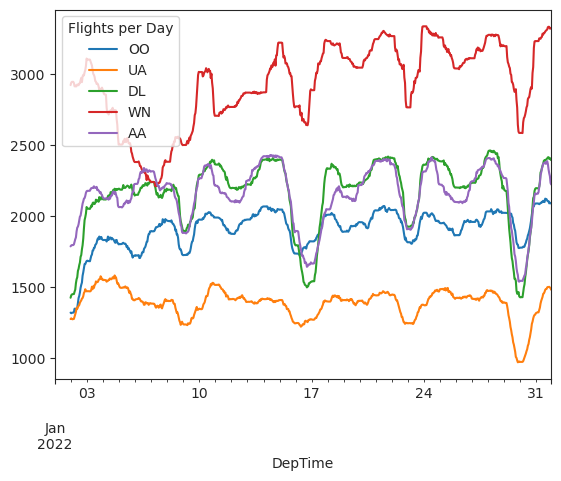

In [10]:
(
    df.to_pandas()
    .dropna(subset=["DepTime", "IATA_CODE_Reporting_Airline"])
    .loc[
        lambda x: x["IATA_CODE_Reporting_Airline"].isin(
            x["IATA_CODE_Reporting_Airline"].value_counts().index[:5]
        )
    ]
    .assign(
        IATA_CODE_Reporting_Airline=lambda x: x[
            "IATA_CODE_Reporting_Airline"
        ].cat.remove_unused_categories()
    )
    .set_index("DepTime")
    # TimeGrouper to resample & groupby at once
    .groupby(["IATA_CODE_Reporting_Airline", pd.Grouper(freq="H")])[
        "Flight_Number_Reporting_Airline"
    ]
    .count()
    .unstack(0)
    .fillna(0)
    .rolling(24)
    .sum()
    .rename_axis("Flights per Day", axis=1)
    .plot()
)


<AxesSubplot: xlabel='DepTime'>

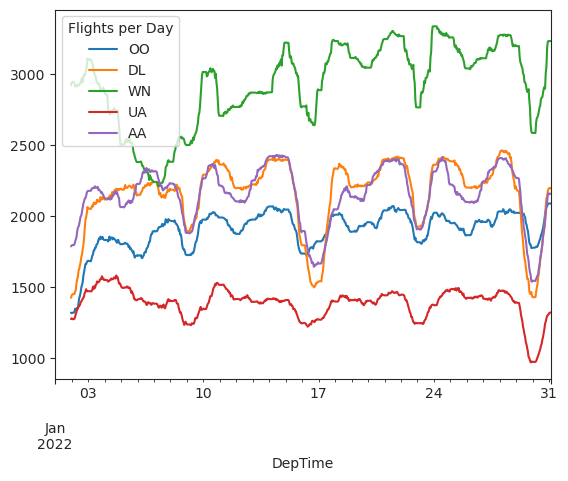

In [11]:
filter_expr = pl.col("IATA_CODE_Reporting_Airline").is_in(
    pl.col("IATA_CODE_Reporting_Airline")
    .value_counts(sort=True)
    .struct.field("IATA_CODE_Reporting_Airline")
    .head(5)
)
(
    df.drop_nulls(subset=["DepTime", "IATA_CODE_Reporting_Airline"])
    .filter(filter_expr)
    .sort("DepTime")
    .groupby_dynamic("DepTime", every="1h", by="IATA_CODE_Reporting_Airline")
    .agg(pl.col("Flight_Number_Reporting_Airline").count())
    .pivot(
        index="DepTime",
        columns="IATA_CODE_Reporting_Airline",
        values="Flight_Number_Reporting_Airline",
    )
    .upsample(time_column="DepTime", every="1h")
    .fill_null(0)
    .sort("DepTime")
    .select([pl.col("DepTime"), pl.col(pl.UInt32).rolling_sum(24)])
    .to_pandas()
    .set_index("DepTime")
    .rename_axis("Flights per Day", axis=1)
    .plot()
)


(-50.0, 50.0)

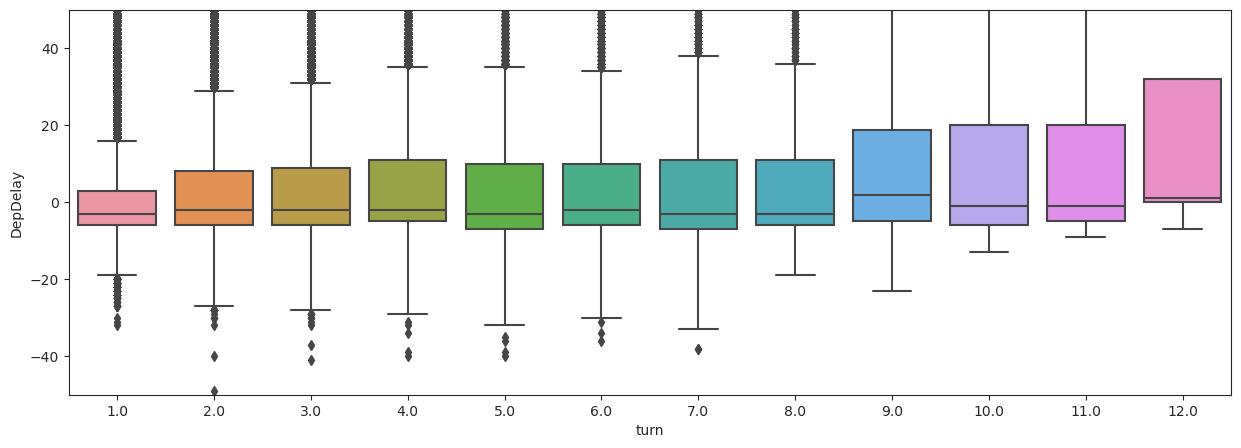

In [12]:
flights = (
    df.select(pl.col(["FlightDate", "Tail_Number", "DepTime", "DepDelay"]))
    .drop_nulls()
    .filter(pl.col("DepDelay") < 500)
    .with_column(
        pl.col("DepTime").rank().over(["FlightDate", "Tail_Number"]).alias("turn")
    )
)

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="turn", y="DepDelay", data=flights.to_pandas(), ax=ax)
ax.set_ylim(-50, 50)


<AxesSubplot: xlabel='hour', ylabel='DepDelay'>

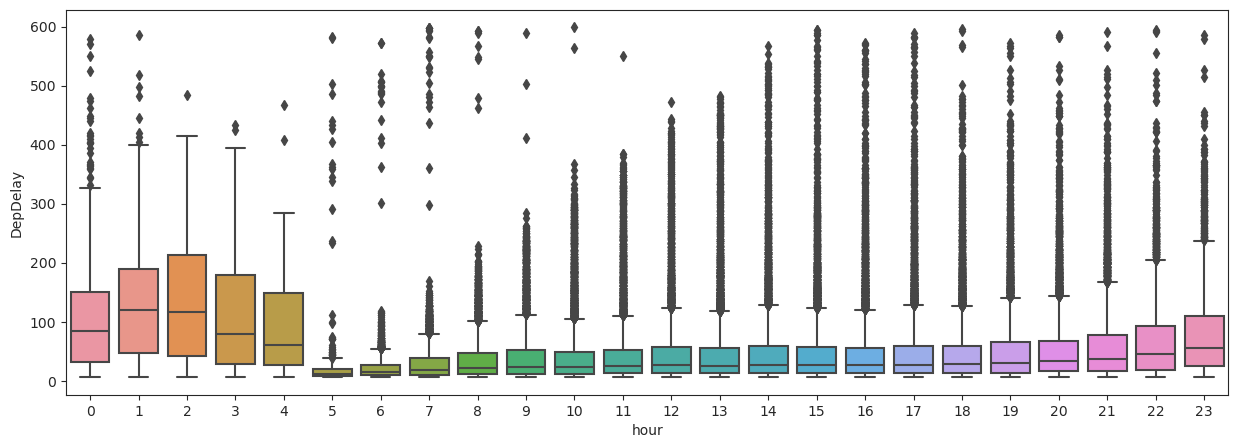

In [13]:
plt.figure(figsize=(15, 5))
(
    df.select(
        pl.col(
            ["FlightDate", "Tail_Number", "DepTime", "DepDelay"],
        )
    )
    .drop_nulls()
    .filter(pl.col("DepDelay").is_between(5, 600))
    .with_column(pl.col("DepTime").dt.hour().alias("hour"))
    .to_pandas()
    .pipe((sns.boxplot, "data"), x="hour", y="DepDelay")
)


# Performance

In [14]:
def gcd_vec(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    ϕ1 = np.deg2rad(90 - lat1)
    ϕ2 = np.deg2rad(90 - lat2)

    θ1 = np.deg2rad(lng1)
    θ2 = np.deg2rad(lng2)

    cos = np.sin(ϕ1) * np.sin(ϕ2) * np.cos(θ1 - θ2) + np.cos(ϕ1) * np.cos(ϕ2)
    arc = np.arccos(cos)
    return arc * 6373


def gcd_arrow(lat1, lng1, lat2, lng2):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers
    ϕ1 = deg2rad_arrow(pc.subtract(90, lat1))
    ϕ2 = deg2rad_arrow(pc.subtract(90, lat2))

    θ1 = deg2rad_arrow(lng1)
    θ2 = deg2rad_arrow(lng2)

    sine_prod = pc.multiply(pc.sin(ϕ1), pc.sin(ϕ2))
    cosine_diff = pc.cos(pc.subtract(θ1, θ2))
    cos_prod = pc.multiply(pc.cos(ϕ1), pc.cos(ϕ2))
    cos = pc.add(pc.multiply(sine_prod, cosine_diff), cos_prod)
    arc = pc.acos(cos)
    return pc.multiply(arc, 6373)


def deg2rad_pl(degrees: pl.Expr) -> pl.Expr:
    return degrees * math.pi / 180


def deg2rad_arrow(degrees: pl.Expr) -> pl.Expr:
    return pc.multiply(degrees, math.pi / 180)


def gcd_pl(lat1: pl.Expr, lng1: pl.Expr, lat2: pl.Expr, lng2: pl.Expr):
    """
    Calculate great circle distance.
    http://www.johndcook.com/blog/python_longitude_latitude/

    Parameters
    ----------
    lat1, lng1, lat2, lng2: float or array of float

    Returns
    -------
    distance:
      distance from ``(lat1, lng1)`` to ``(lat2, lng2)`` in kilometers.
    """
    # python2 users will have to use ascii identifiers
    ϕ1 = deg2rad_pl(90 - lat1)
    ϕ2 = deg2rad_pl(90 - lat2)

    θ1 = deg2rad_pl(lng1)
    θ2 = deg2rad_pl(lng2)

    cos = ϕ1.sin() * ϕ2.sin() * (θ1 - θ2).cos() + ϕ1.cos() * ϕ2.cos()
    arc = cos.arccos()
    return arc * 6373


In [15]:
airports = pl.scan_csv("data/airports.csv").drop_nulls().unique(subset=["AIRPORT"])
pairs = airports.join(airports, on="AIRPORT", how="cross").filter(
    pl.col("AIRPORT") != pl.col("AIRPORT_right")
)


In [64]:
%%timeit
collected = pairs.collect()
gcd_arrow(collected["LATITUDE"].to_arrow(), collected["LONGITUDE"].to_arrow(), collected["LATITUDE_right"].to_arrow(), collected["LONGITUDE_right"].to_arrow())

6.64 s ± 589 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%%timeit
collected = pairs.collect()
gcd_vec(collected["LATITUDE"].to_numpy(), collected["LONGITUDE"].to_numpy(), collected["LATITUDE_right"].to_numpy(), collected["LONGITUDE_right"].to_numpy())

/tmp/ipykernel_14936/3589155608.py:22: RuntimeWarning: invalid value encountered in arccos
  arc = np.arccos(cos)


5.53 s ± 61.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%%timeit
pairs.select(gcd_pl(pl.col("LATITUDE"), pl.col("LONGITUDE"), pl.col("LATITUDE_right"), pl.col("LONGITUDE_right"))).collect()

4.4 s ± 65.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
def create_frame(n, n_groups):
    return pd.DataFrame(
        {"name": np.random.randint(0, n_groups, size=n), "value2": np.random.randn(n)}
    )


rand_df_pd = create_frame(50_000_000, 50_000)
rand_df_pl = pl.from_pandas(rand_df_pd)


def pandas_transform(df: pd.DataFrame) -> pd.DataFrame:
    g = df.groupby("name")["value2"]
    v = df["value2"]
    return (v - g.transform(np.mean)) / g.transform(np.std)


def polars_transform() -> pl.Expr:
    v = pl.col("value2")
    return (v - v.mean().over("name")) / v.std().over("name")


In [20]:
%timeit x=pandas_transform(rand_df_pd)

2.04 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit x=rand_df_pl.select(polars_transform())

2.17 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
import string

s_pd = pd.Series(np.random.choice(list(string.ascii_letters), 100000))
s_pl = pl.from_pandas(s_pd)
print("Pandas string size: {:0.2f} KB".format(s_pd.memory_usage(index=False) / 1000))
print(
    "Pandas categorical size: {:0.2f} KB".format(
        s_pd.astype("category").memory_usage(index=False) / 1000
    )
)
print("Polars string size: {:0.2f} KB".format(s_pl.estimated_size() / 1000))
print(
    "Polars categorical size: {:0.2f} KB".format(
        s_pl.cast(pl.Categorical).estimated_size() / 1000
    )
)


Pandas string size: 800.00 KB
Pandas categorical size: 102.52 KB
Polars string size: 900.01 KB
Polars categorical size: 400.48 KB


# Reshaping and Tidy Data

In [23]:
nba_dir = Path("data/nba/")

column_names = {
    "Date": "date",
    "Visitor/Neutral": "away_team",
    "PTS": "away_points",
    "Home/Neutral": "home_team",
    "PTS.1": "home_points",
}

if not nba_dir.exists():
    nba_dir.mkdir()
    for month in (
        "october",
        "november",
        "december",
        "january",
        "february",
        "march",
        "april",
        "may",
        "june",
    ):
        url = f"http://www.basketball-reference.com/leagues/NBA_2016_games-{month}.html"
        tables = pd.read_html(url)
        raw = (
            pl.from_pandas(tables[0].query("Date != 'Playoffs'"))
            .rename(column_names)
            .select(column_names.values())
        )
        raw.write_csv(nba_dir / f"{month}.csv")

nba_glob = nba_dir / "*.csv"
pl.scan_csv(nba_glob).head().collect()


date,away_team,away_points,home_team,home_points
str,str,i64,str,i64
"""Fri, Apr 1, 20...","""Philadelphia 7...",91,"""Charlotte Horn...",100
"""Fri, Apr 1, 20...","""Dallas Maveric...",98,"""Detroit Piston...",89
"""Fri, Apr 1, 20...","""Brooklyn Nets""",91,"""New York Knick...",105
"""Fri, Apr 1, 20...","""Cleveland Cava...",110,"""Atlanta Hawks""",108
"""Fri, Apr 1, 20...","""Toronto Raptor...",99,"""Memphis Grizzl...",95


In [24]:
games_pd = (
    pl.read_csv(nba_glob)
    .to_pandas()
    .dropna(thresh=4)
    .assign(date=lambda x: pd.to_datetime(x["date"], format="%a, %b %d, %Y"))
    .set_index("date", append=True)
    .rename_axis(["game_id", "date"])
    .sort_index()
)
games_pd.head()


,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2016-04-01,Philadelphia 76ers,91,Charlotte Hornets,100
1,2016-04-01,Dallas Mavericks,98,Detroit Pistons,89
2,2016-04-01,Brooklyn Nets,91,New York Knicks,105
3,2016-04-01,Cleveland Cavaliers,110,Atlanta Hawks,108
4,2016-04-01,Toronto Raptors,99,Memphis Grizzlies,95


In [25]:
games_pl = (
    pl.scan_csv(nba_glob)
    .filter(
        ~pl.fold(
            acc=True,
            f=lambda acc, s: acc & s.is_null(),
            exprs=pl.all(),
        )
    )
    .with_row_count("game_id")
    .with_column(
        pl.col("date").str.strptime(pl.Date, "%a, %b %d, %Y"),
    )
)


In [26]:
games_pl.head().collect()


game_id,date,away_team,away_points,home_team,home_points
u32,date,str,i64,str,i64
0,2016-04-01,"""Philadelphia 7...",91,"""Charlotte Horn...",100
1,2016-04-01,"""Dallas Maveric...",98,"""Detroit Piston...",89
2,2016-04-01,"""Brooklyn Nets""",91,"""New York Knick...",105
3,2016-04-01,"""Cleveland Cava...",110,"""Atlanta Hawks""",108
4,2016-04-01,"""Toronto Raptor...",99,"""Memphis Grizzl...",95


In [27]:
tidy_pl = (
    games_pl.melt(
        id_vars=["game_id", "date"],
        value_vars=["away_team", "home_team"],
        value_name="team",
    )
    .sort("date")
    .with_column(pl.col("date").alias("rest").diff().over("team").dt.days() - 1)
    .drop_nulls("rest")
    .collect()
)


In [28]:
tidy_pd = (
    games_pd.reset_index()
    .melt(
        id_vars=["game_id", "date"],
        value_vars=["away_team", "home_team"],
        value_name="team",
    )
    .assign(
        rest=lambda df: df.sort_values("date").groupby("team")["date"].diff().dt.days
        - 1
    )
    .dropna(subset=["rest"])
)
tidy_pd


,game_id,date,variable,team,rest
0,0,2016-04-01,away_team,Philadelphia 76ers,2.0
1,1,2016-04-01,away_team,Dallas Mavericks,1.0
...,...,...,...,...,...
2630,1314,2015-10-31,home_team,Portland Trail Blazers,0.0
2631,1315,2015-10-31,home_team,Los Angeles Clippers,1.0


In [29]:
by_game_pd = tidy_pd.pivot(
    values="rest", index=["game_id", "date"], columns="variable"
).rename(columns={"away_team": "away_rest", "home_team": "home_rest"})

by_game_pl = tidy_pl.pivot(
    values="rest", index=["game_id", "date"], columns="variable"
).rename({"away_team": "away_rest", "home_team": "home_rest"})
joined_pd = by_game_pd.join(games_pd).assign(
    home_win=lambda df: df["home_points"] > df["away_points"],
    rest_spread=lambda df: df["home_rest"] - df["away_rest"],
)
joined_pl = by_game_pl.join(games_pl, on=["game_id", "date"]).with_columns(
    [
        pl.col("home_points").alias("home_win") > pl.col("away_points"),
        pl.col("home_rest").alias("rest_spread") - pl.col("away_rest"),
    ]
)


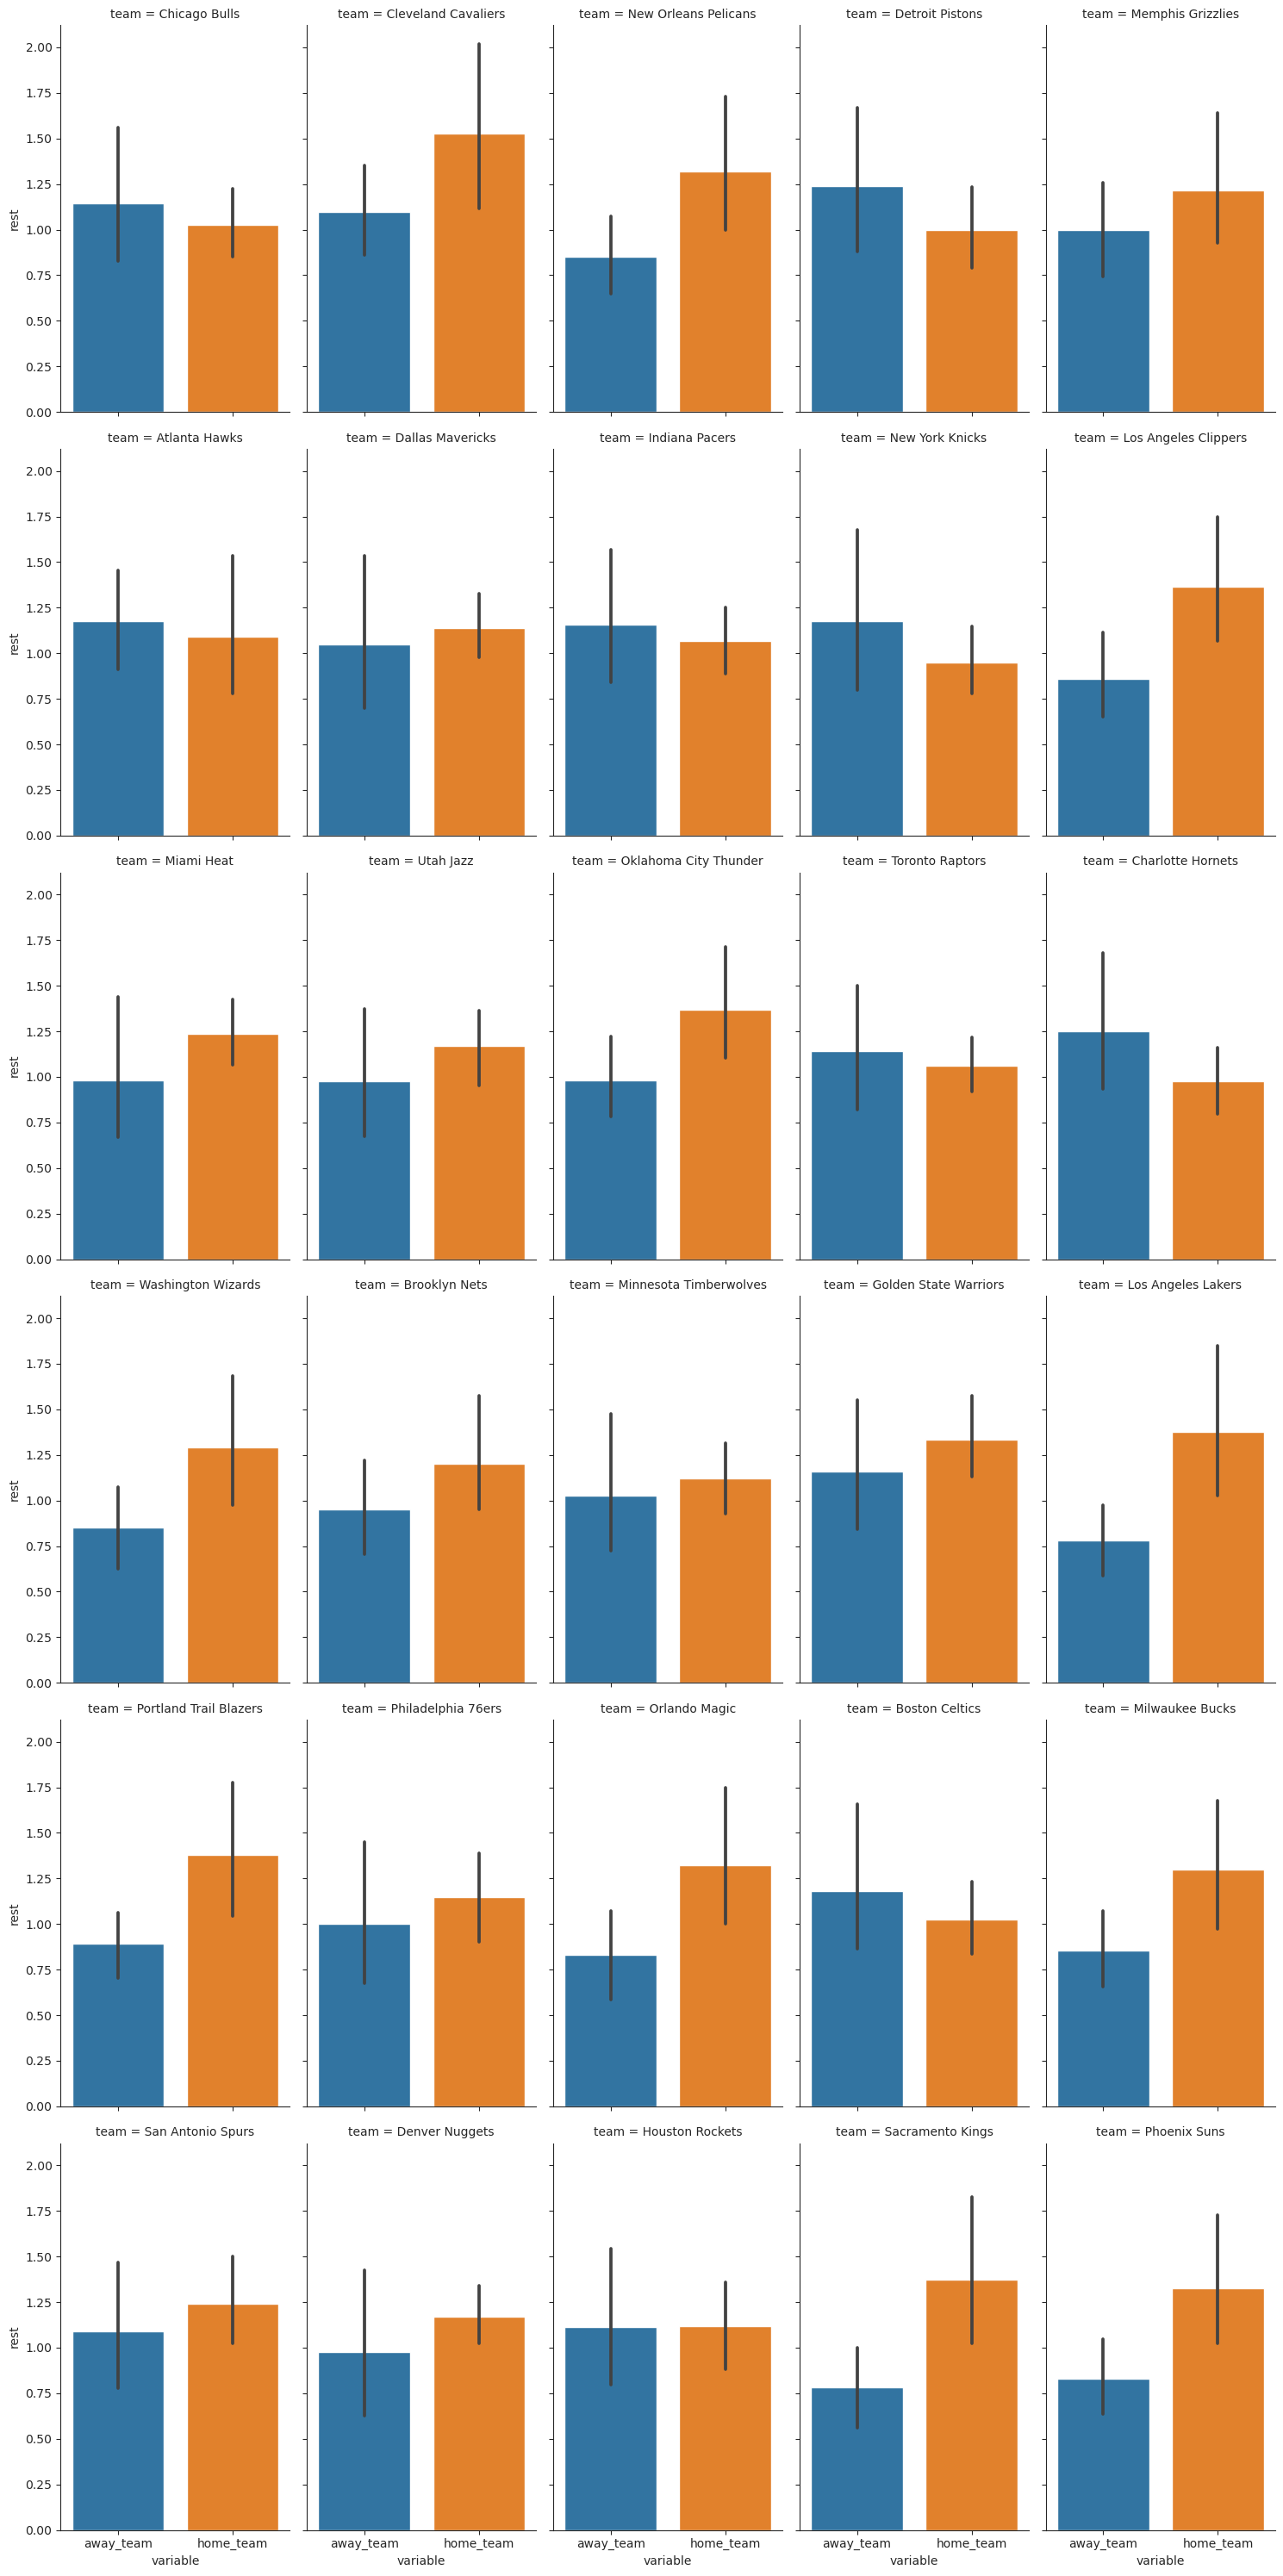

In [30]:
sns.catplot(
    tidy_pl.to_pandas(),
    x="variable",
    y="rest",
    col="team",
    col_wrap=5,
    kind="bar",
    aspect=0.6,
)


[Text(0.5, 0, 'Difference in Rest (Home - Away)'), Text(0, 0.5, 'Games')]

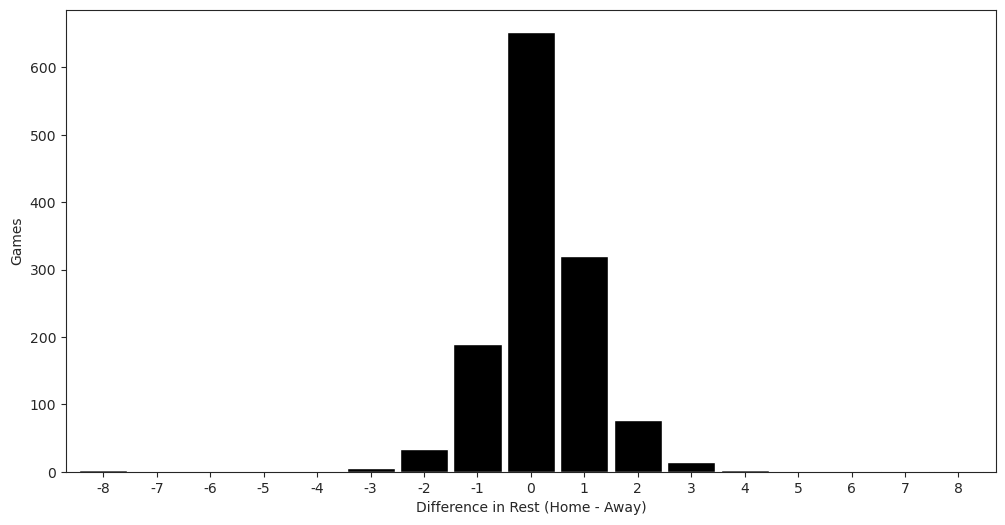

In [31]:
delta = joined_pl["rest_spread"]
ax = (
    delta.to_pandas()
    .value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind="bar", color="k", width=0.9, rot=0, figsize=(12, 6))
)
ax.set(xlabel="Difference in Rest (Home - Away)", ylabel="Games")


<AxesSubplot: xlabel='rest_spread', ylabel='home_win'>

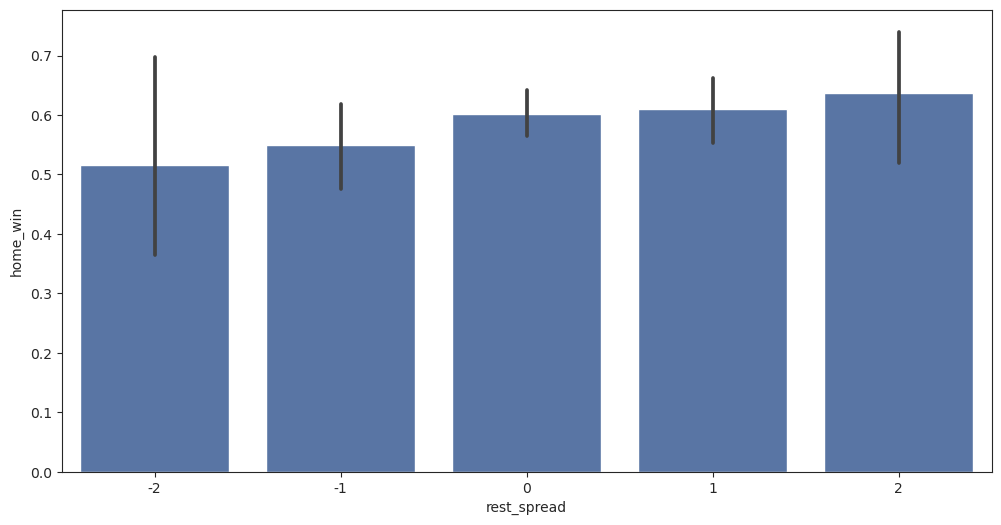

In [32]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="rest_spread",
    y="home_win",
    data=joined_pl.filter(pl.col("rest_spread").is_between(-3, 3)).to_pandas(),
    color="#4c72b0",
    ax=ax,
)


In [33]:
rest_pl = tidy_pl.groupby(["date", "variable"]).agg(pl.col("rest").mean())


[Text(0, 0.5, 'Rest (7 day MA)')]

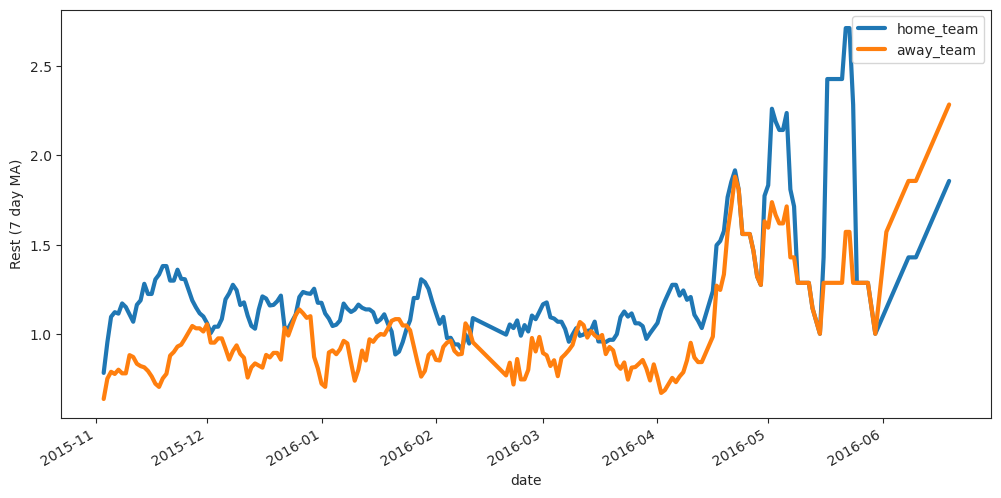

In [34]:
ax = (
    rest_pl.pivot(index="date", values="rest", columns="variable")
    .filter(pl.col("away_team") < 7)
    .sort("date")
    .select([pl.col("date"), pl.col(pl.Float64).rolling_mean(7)])
    .to_pandas()
    .set_index("date")
    .plot(figsize=(12, 6), linewidth=3)
)
ax.set(ylabel="Rest (7 day MA)")


In [35]:
win_col = pl.col("win")
wins = (
    joined_pl.melt(
        id_vars=["game_id", "date", "home_win"],
        value_name="team",
        variable_name="is_home",
        value_vars=["home_team", "away_team"],
    )
    .with_column(pl.col("home_win").alias("win") == (pl.col("is_home") == "home_team"))
    .groupby(["team", "is_home"])
    .agg(
        [
            win_col.sum().alias("n_wins"),
            win_col.count().alias("n_games"),
            win_col.mean().alias("win_pct"),
        ]
    )
)
wins.head()


team,is_home,n_wins,n_games,win_pct
str,str,u32,u32,f64
"""Milwaukee Buck...","""home_team""",23,40,0.575
"""Memphis Grizzl...","""away_team""",16,43,0.372093
"""Milwaukee Buck...","""away_team""",10,41,0.243902
"""Chicago Bulls""","""home_team""",25,40,0.625
"""Los Angeles Cl...","""home_team""",31,44,0.704545


/home/user/mambaforge/envs/modern-polars/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


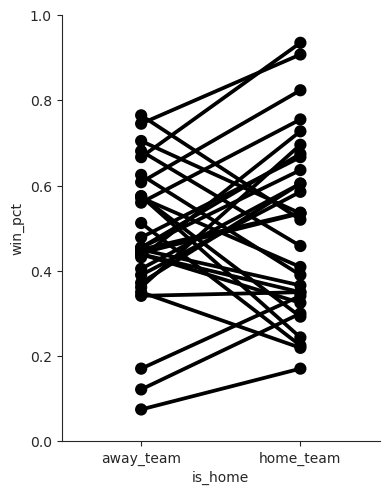

In [36]:
g = sns.FacetGrid(wins.to_pandas(), hue="team", aspect=0.8, palette=["k"], height=5)
g.map(sns.pointplot, "is_home", "win_pct").set(ylim=(0, 1))


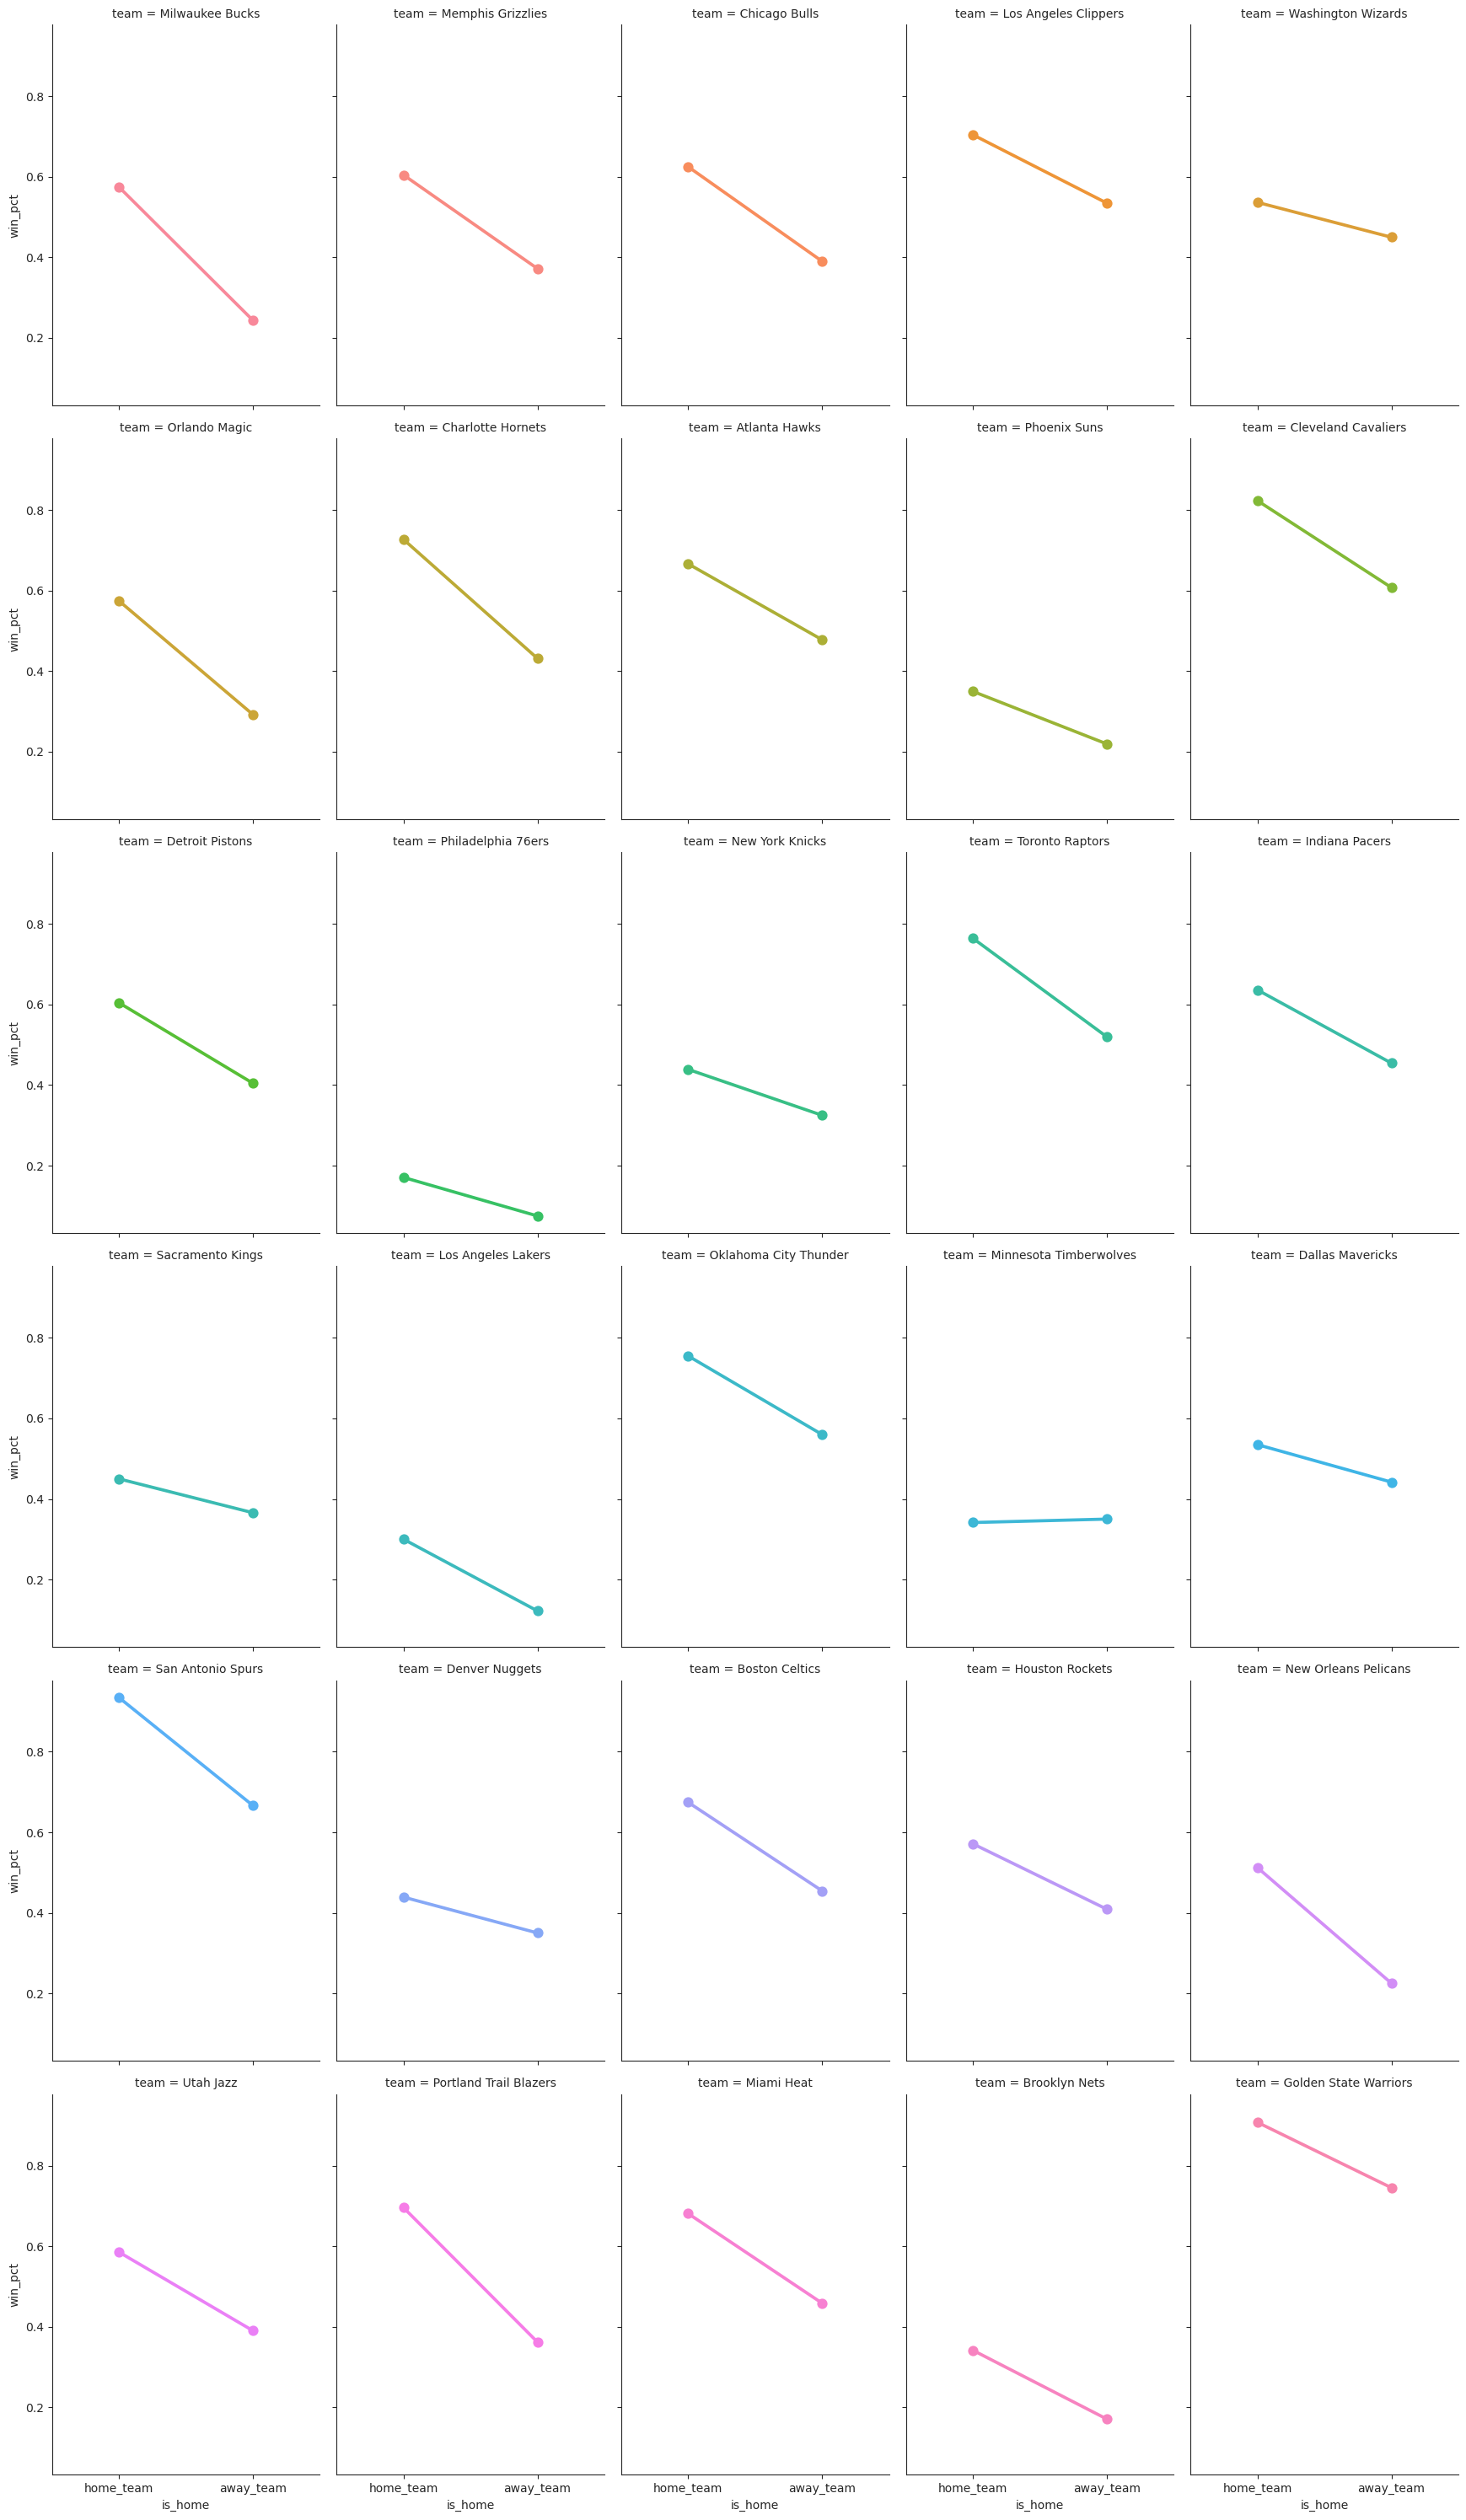

In [37]:
sns.catplot(
    wins.to_pandas(),
    x="is_home",
    y="win_pct",
    col="team",
    col_wrap=5,
    hue="team",
    kind="point",
    aspect=0.7,
)


In [38]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby("team").agg(
        pl.col("n_wins").sum().alias("win_pct") / pl.col("n_games").sum()
    )
)
win_percent.head()


team,win_pct
str,f64
"""Utah Jazz""",0.487805
"""Washington Wiz...",0.493827
"""New York Knick...",0.382716
"""New Orleans Pe...",0.37037
"""Brooklyn Nets""",0.256098


Text(0.5, 102.72222222222219, 'Win Percent')

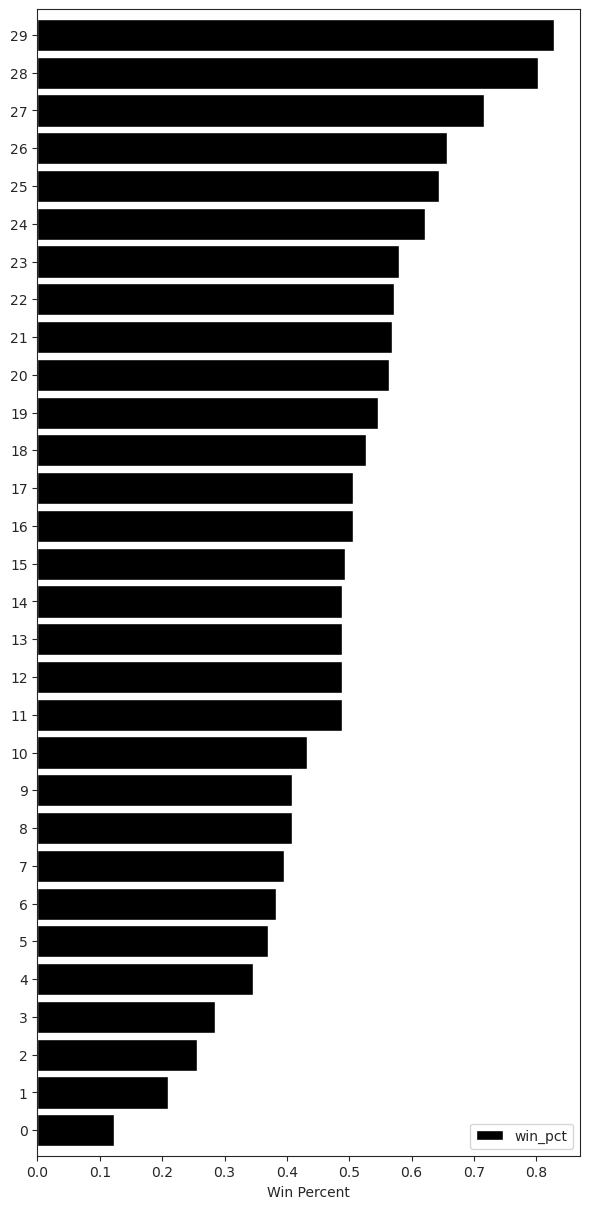

In [39]:
win_percent.sort("win_pct").to_pandas().plot.barh(
    figsize=(6, 12), width=0.85, color="k"
)
plt.tight_layout()
plt.xlabel("Win Percent")


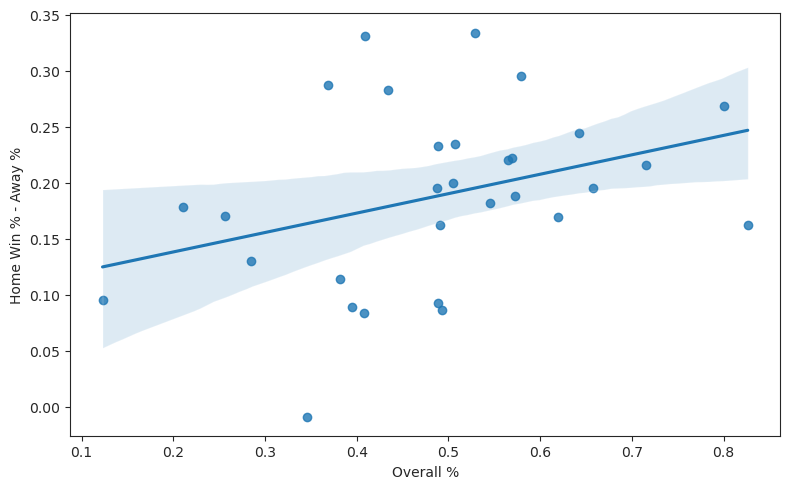

In [40]:
plt.figure(figsize=(8, 5))
(
    wins.pivot(index="team", columns="is_home", values="win_pct")
    .with_columns(
        [
            pl.col("home_team").alias("Home Win % - Away %") - pl.col("away_team"),
            (pl.col("home_team").alias("Overall %") + pl.col("away_team")) / 2,
        ]
    )
    .to_pandas()
    .pipe((sns.regplot, "data"), x="Overall %", y="Home Win % - Away %")
)
plt.tight_layout()


In [41]:
reg_df = (
    joined_pl.join(win_percent, left_on="home_team", right_on="team")
    .rename({"win_pct": "home_strength"})
    .join(win_percent, left_on="away_team", right_on="team")
    .rename({"win_pct": "away_strength"})
    .with_columns(
        [
            pl.col("home_points").alias("point_diff") - pl.col("away_points"),
            pl.col("home_rest").alias("rest_diff") - pl.col("away_rest"),
            pl.col("home_win").cast(pl.UInt8),  # for statsmodels
        ]
    )
)


In [42]:
import statsmodels.formula.api as sm

mod = sm.logit(
    "home_win ~ home_strength + away_strength + home_rest + away_rest",
    reg_df.to_pandas(),
)
res = mod.fit()
res.summary()


Optimization terminated successfully.
         Current function value: 0.554797
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               home_win   No. Observations:                 1299
Model:                          Logit   Df Residuals:                     1294
Method:                           MLE   Df Model:                            4
Date:                Thu, 22 Dec 2022   Pseudo R-squ.:                  0.1777
Time:                        16:21:41   Log-Likelihood:                -720.68
converged:                       True   LL-Null:                       -876.38
Covariance Type:            nonrobust   LLR p-value:                 3.748e-66
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0019      0.304     -0.006      0.995      -0.597       0.593
home_strength     5.7161      0.466     12.272      0.000       4.803       6.629
away_strength    -4.9133      0.456    -10.786      0.000      -5.806      -4.020
home_rest         0.1045      0.076      1.381      0.167      -0.044       0.253
away_rest        -0.0347      0.066     -0.526      0.599      -0.164       0.095
=================================================================================
"""

# Time series

In [43]:
import requests
from io import StringIO


def epoch_ms(dt: datetime) -> int:
    return int(dt.timestamp()) * 1000


start = epoch_ms(datetime(2021, 1, 1))
end = epoch_ms(datetime(2022, 1, 1))


In [44]:
url = (
    "https://api.binance.com/api/v3/klines?symbol=BTCUSDT&"
    f"interval=1d&startTime={start}&endTime={end}"
)
resp = requests.get(url)


In [45]:
cols_to_use = [
    "time",
    "open",
    "high",
    "low",
    "close",
    "volume",
]
cols = cols_to_use + [f"ignore_{i}" for i in range(6)]
ohlcv = pl.from_records(resp.json(), orient="row", columns=cols).select(
    [
        pl.col("time").cast(pl.Datetime).dt.with_time_unit("ms").cast(pl.Date),
        pl.col(["open", "high", "low", "close", "volume"]).cast(pl.Float64),
    ]
)
ohlcv_pd = (
    pd.DataFrame.from_records(resp.json(), columns=cols)
    .assign(time=lambda df: pd.to_datetime(df["time"], unit="ms"))[cols_to_use]
    .set_index("time")
    .astype("float")
)


In [46]:
ohlcv_pd


,open,high,low,close,volume
time,,,,,
2021-01-01,28923.63,29600.00,28624.57,29331.69,54182.925011
2021-01-02,29331.70,33300.00,28946.53,32178.33,129993.873362
...,...,...,...,...,...
2021-12-31,47120.88,48548.26,45678.00,46216.93,34937.997960
2022-01-01,46216.93,47954.63,46208.37,47722.65,19604.463250


## Filtering

In [47]:
ohlcv.filter(pl.col("time").is_between(date(2021, 2, 1), date(2021, 3, 1))).head()


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-02-02,33517.09,35984.33,33418.0,35466.24,78056.65988
2021-02-03,35472.71,37662.63,35362.38,37618.87,80784.333663
2021-02-04,37620.26,38708.27,36161.95,36936.66,92080.735898
2021-02-05,36936.65,38310.12,36570.0,38290.24,66681.334275
2021-02-06,38289.32,40955.51,38215.94,39186.94,98757.311183


### Downsampling

In [48]:
ohlcv.groupby_dynamic("time", every="5d").agg(pl.col(pl.Float64).mean()).head()


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-01-01,31084.316,33127.622,29512.818,32089.662,112416.84957
2021-01-06,38165.31,40396.842,35983.822,39004.538,118750.076685
2021-01-11,36825.226,38518.1,33288.046,36542.762,146166.703112
2021-01-16,36216.36,37307.528,34650.372,35962.916,81236.801666
2021-01-21,32721.534,34165.706,30624.232,32077.48,97809.662654


In [49]:
ohlcv.groupby_dynamic("time", every="1w").agg(
    [pl.col(pl.Float64).mean().suffix("_mean"), pl.col(pl.Float64).sum().suffix("_sum")]
).head()


time,open_mean,high_mean,low_mean,close_mean,volume_mean,open_sum,high_sum,low_sum,close_sum,volume_sum
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2021-01-01,32305.781429,34706.045714,31021.727143,33807.135714,117435.5928,226140.47,242942.32,217152.09,236649.95,822049.149598
2021-01-08,37869.797143,39646.105714,34623.334286,37827.52,135188.296617,265088.58,277522.74,242363.34,264792.64,946318.076319
2021-01-15,36527.891429,37412.2,33961.551429,35343.847143,94212.715129,255695.24,261885.4,237730.86,247406.93,659489.005903
2021-01-22,31888.547143,33498.811429,30424.478571,32248.007143,89649.935836,223219.83,234491.68,212971.35,225736.05,627549.550849
2021-01-29,34511.482857,36411.441429,33450.08,35022.314286,102728.42481,241580.38,254880.09,234150.56,245156.2,719098.973673


### Upsampling

In [50]:
ohlcv.upsample("time", every="6h")


time,open,high,low,close,volume
date,f64,f64,f64,f64,f64
2021-01-01,28923.63,29600.0,28624.57,29331.69,54182.925011
2021-01-01,null,null,null,null,null
2021-01-01,null,null,null,null,null
2021-01-01,null,null,null,null,null
2021-01-02,29331.7,33300.0,28946.53,32178.33,129993.873362
2021-01-02,null,null,null,null,null
2021-01-02,null,null,null,null,null
2021-01-02,null,null,null,null,null
2021-01-03,32176.45,34778.11,31962.99,33000.05,120957.56675


In [51]:
ohlcv_pd["close"]


time
2021-01-01    29331.69
2021-01-02    32178.33
                ...   
2021-12-31    46216.93
2022-01-01    47722.65
Name: close, Length: 366, dtype: float64

In [52]:
ohlcv_pd["close"].expanding().mean()


time
2021-01-01    29331.690000
2021-01-02    30755.010000
                  ...     
2021-12-31    47400.003041
2022-01-01    47400.884590
Name: close, Length: 366, dtype: float64

In [53]:
def add(curr, prev):
    return curr + prev


ohlcv.select(pl.col("close").cumsum() / (pl.col("close").cumcount() + 1))


close
f64
29331.69
30755.01
31503.356667
31624.695
32089.662
32869.611667
33807.135714
34654.095
35257.886667


Text(0, 0.5, 'Close ($)')

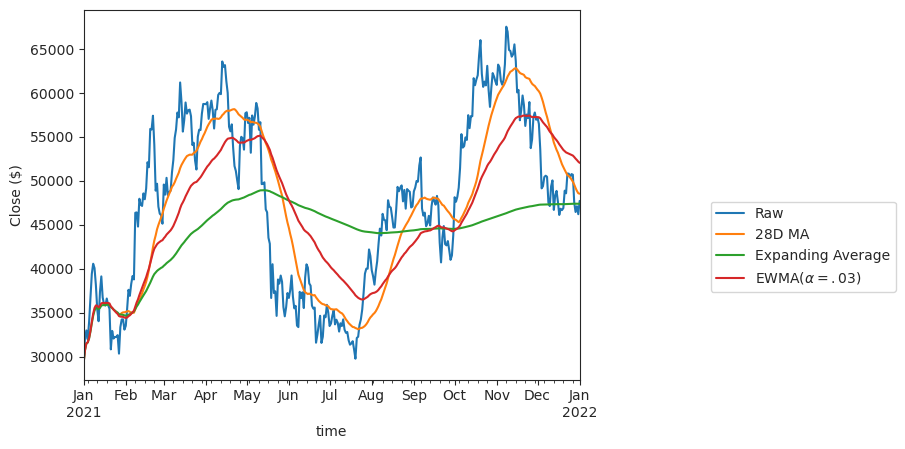

In [54]:
ohlcv_pd["close"].plot(label="Raw")
ohlcv_pd["close"].rolling(28).mean().plot(label="28D MA")
ohlcv_pd["close"].expanding().mean().plot(label="Expanding Average")
ohlcv_pd["close"].ewm(alpha=0.03).mean().plot(label="EWMA($\\alpha=.03$)")

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(0, 0.5, 'Close ($)')

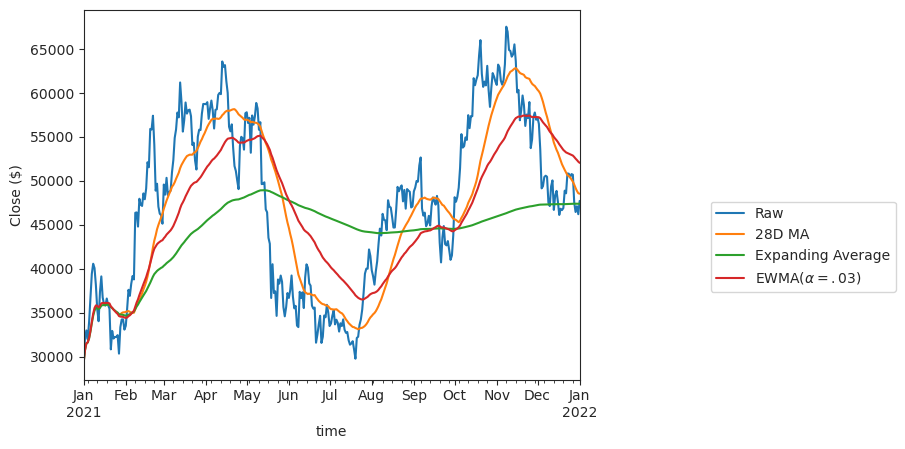

In [55]:
ohlcv.select(
    [
        pl.col("time"),
        pl.col("close").alias("Raw"),
        pl.col("close").rolling_mean(28).alias("28D MA"),
        pl.col("close").alias("Expanding Average").cumsum()
        / (pl.col("close").cumcount() + 1),
        pl.col("close").ewm_mean(alpha=0.03).alias("EWMA($\\alpha=.03$)"),
    ]
).to_pandas().set_index("time").plot()

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(0, 0.5, 'Close ($)')

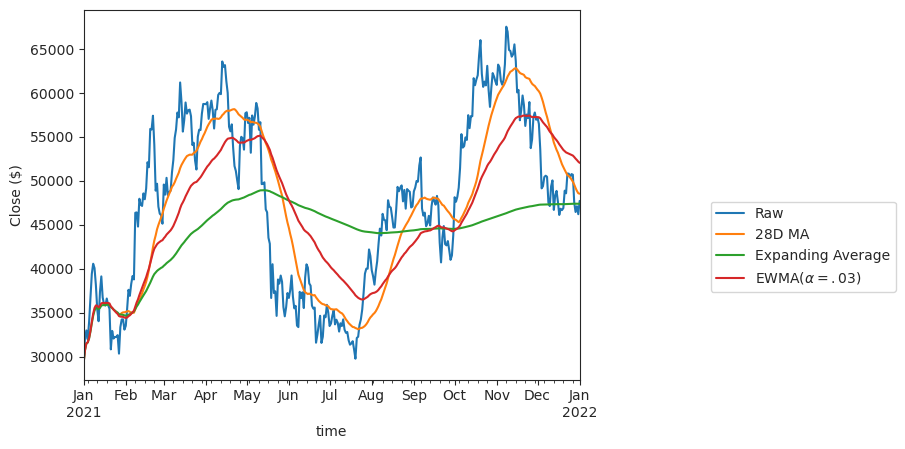

In [56]:
ohlcv_pd["close"].plot(label="Raw")
ohlcv_pd["close"].rolling(28).mean().plot(label="28D MA")
ohlcv_pd["close"].expanding().mean().plot(label="Expanding Average")
ohlcv_pd["close"].ewm(alpha=0.03).mean().plot(label="EWMA($\\alpha=.03$)")

plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.ylabel("Close ($)")


Text(20.347222222222214, 0.5, 'Close ($)')

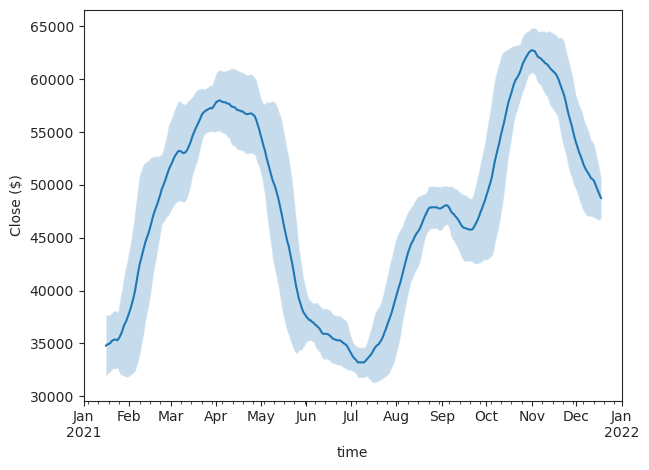

In [57]:
roll_pd = ohlcv_pd["close"].rolling(30, center=True)
mean_std_pd = roll_pd.agg(["mean", "std"])
ax = mean_std_pd["mean"].plot()
ax.fill_between(
    mean_std_pd.index,
    mean_std_pd["mean"] - mean_std_pd["std"],
    mean_std_pd["mean"] + mean_std_pd["std"],
    alpha=0.25,
)
plt.tight_layout()
plt.ylabel("Close ($)")


Text(20.347222222222214, 0.5, 'Close ($)')

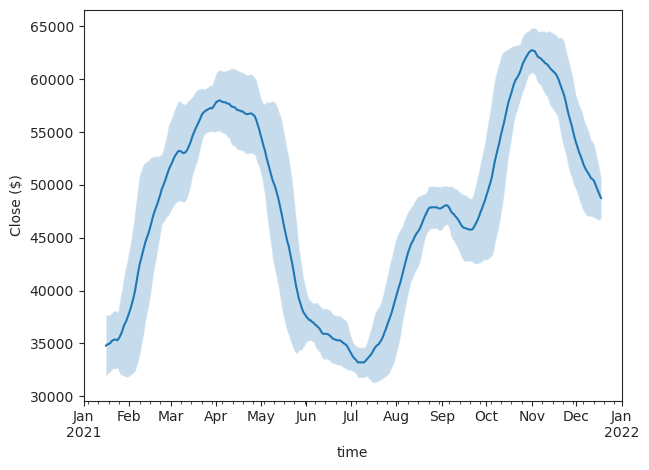

In [58]:
mean_std_pl = ohlcv.select(
    [
        "time",
        pl.col("close").rolling_mean(30, center=True).alias("mean"),
        pl.col("close").rolling_std(30, center=True).alias("std"),
    ]
)
ax = mean_std_pl.to_pandas().set_index("time")["mean"].plot()
ax.fill_between(
    mean_std_pl["time"].to_numpy(),
    mean_std_pl["mean"] - mean_std_pl["std"],
    mean_std_pl["mean"] + mean_std_pl["std"],
    alpha=0.25,
)
plt.tight_layout()
plt.ylabel("Close ($)")


## Grab Bag

### Offsets

Note: month offsets are ambiguous so don't use them in pandas

In [59]:
ohlcv.select(pl.col("time") + pl.duration(days=80)).head()


time
date
2021-03-22
2021-03-23
2021-03-24
2021-03-25
2021-03-26


### Holidays

Not supported in Polars yet. See [open issue](https://github.com/pola-rs/polars/issues/5713).

### Timezones

This basically says, "assume these times are UTC, now tell me what time it was in US/Eastern

In [60]:
ohlcv.select(pl.col("time").cast(pl.Datetime).dt.with_time_zone("US/Eastern")).head()


time
"datetime[μs, US/Eastern]"
2020-12-31 19:00:00 EST
2021-01-01 19:00:00 EST
2021-01-02 19:00:00 EST
2021-01-03 19:00:00 EST
2021-01-04 19:00:00 EST
